# Лабораторная работа №4 «Определение числовых характеристик выборки»

## Задание 1

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


df = pd.read_csv("DataBikes_new.csv")
df_describe = df.select_dtypes(include='number').copy()
display(df_describe)

,Unnamed: 0,Hour,Temperature,Humidity,Wind speed,Rainfall,Snowfall,Rental count,score
0,0,0,-5.2,37,2.2,0.0,0.0,257,56.0
1,1,1,-5.5,38,0.8,0.0,0.0,219,3.0
2,2,2,-6.0,39,1.0,0.0,0.0,162,7.0
3,3,3,-6.2,40,0.9,0.0,0.0,148,8.0
4,4,4,-6.0,36,2.3,0.0,0.0,97,10.0
...,...,...,...,...,...,...,...,...,...
8755,8755,19,4.2,34,2.6,0.0,0.0,644,55.0
8756,8756,20,3.4,37,2.3,0.0,0.0,359,10.0
8757,8757,21,2.6,39,0.3,0.0,0.0,1236,8.0
8758,8758,22,2.1,41,1.0,0.0,0.0,628,8.0


## 2. Статистики температуры по сезонам

In [10]:
grouped = df.groupby('Seasons')['Temperature']

stats = pd.DataFrame({
    'mean': grouped.mean(),
    'median': grouped.median(),
    'mode': grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    'variance': grouped.var(),
    'std': grouped.std(),
    'range': grouped.max() - grouped.min(),
    'IQR': grouped.quantile(0.75) - grouped.quantile(0.25)
})
display(stats)

,mean,median,mode,variance,std,range,IQR
Seasons,,,,,,,
Autumn,14.138821,13.8,10.8,49.589573,7.041986,33.5,11.1
Spring,13.038533,13.3,9.6,43.665630,6.607997,36.0,9.9
Summer,26.574827,26.6,23.4,21.655814,4.653581,23.1,6.7
Winter,-2.567783,-2.2,-1.8,29.877730,5.466052,28.1,7.7


## 3. Замена пропущенных значений в Temperature

In [11]:
# Создаём копию
df_filled = df.copy()

# Группируем по Seasons и Hour, заполняем пропуски средним в группе
df_filled['Temperature'] = df_filled.groupby(['Seasons', 'Hour'])['Temperature'].transform(
    lambda x: x.fillna(x.mean())
)

print("До:", df['Temperature'].describe())
print()
print("После:", df_filled['Temperature'].describe())

До: count    8581.000000
mean       12.878557
std        11.955551
min       -17.800000
25%         3.400000
50%        13.700000
75%        22.500000
max        39.400000
Name: Temperature, dtype: float64

После: count    8760.000000
mean       12.874765
std        11.918847
min       -17.800000
25%         3.500000
50%        13.700000
75%        22.500000
max        39.400000
Name: Temperature, dtype: float64


## 4. Удаление выбросов

In [12]:
df_no_outliers = df_filled.copy()

season_stats = df_no_outliers.groupby('Seasons')['Temperature'].agg(['mean', 'std']).reset_index()

# Слияние со статистиками
df_no_outliers = df_no_outliers.merge(season_stats, on='Seasons')

# Фильтрация: оставить только те, где |T - mean| <= 2*std
df_no_outliers = df_no_outliers[
    np.abs(df_no_outliers['Temperature'] - df_no_outliers['mean']) <= 2 * df_no_outliers['std']
]

# Сравнение средних
print("Исходное среднее:", df_filled['Temperature'].mean())
print("Без выбросов:", df_no_outliers['Temperature'].mean())

Исходное среднее: 12.874764790276942
Без выбросов: 12.962065115192923


## 5. График размаха температуры по месяцам

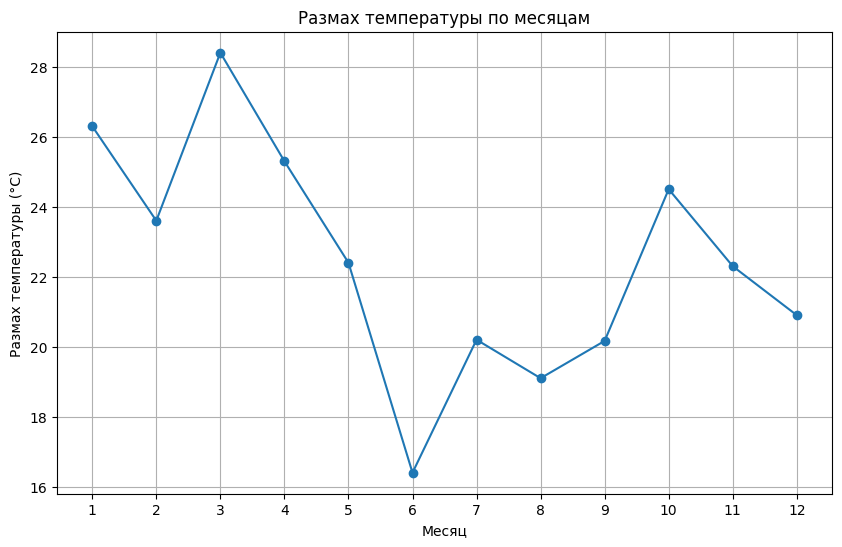

In [13]:
df_plot = df_filled.copy()
df_plot['Date'] = pd.to_datetime(df_plot['Date'], dayfirst=True)
df_plot['Month'] = df_plot['Date'].dt.month

monthly_range = df_plot.groupby('Month')['Temperature'].apply(lambda x: x.max() - x.min())

plt.figure(figsize=(10,6))
plt.plot(monthly_range.index, monthly_range.values, marker='o')
plt.title('Размах температуры по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Размах температуры (°C)')
plt.xticks(range(1,13))
plt.grid(True)
plt.show()

## 6. Сколько дней работа проката по оценкам была выше среднего.

In [14]:
df_z = df_filled.copy()
df_z['z_score'] = df_z.groupby('score_type')['score'].transform(
    lambda x: (x - x.mean()) / x.std()
)

df_z['Date'] = pd.to_datetime(df_z['Date'], dayfirst=True)

daily_z = df_z.groupby('Date')['z_score'].mean()

above_avg_days = (daily_z > 0).sum()
print(f"Дней с оценкой выше среднего: {above_avg_days}")

Дней с оценкой выше среднего: 182


## 7. Наличие линейной зависимости между температурой и числом арендованных велосипедов

In [15]:

df_analysis = df_filled.copy()
df_analysis['Date'] = pd.to_datetime(df_analysis['Date'], dayfirst=True)
df_analysis['Month'] = df_analysis['Date'].dt.month
df_analysis = df_analysis.dropna(subset=['Temperature', 'Rental count'])

best_r = 0
best_group_desc = ""

print("Корреляция между температурой и числом аренд:")


# Весь год
r_all, _ = pearsonr(df_analysis['Temperature'], df_analysis['Rental count'])
print(f"Весь год:                      r = {r_all: .4f}")
if abs(r_all) > abs(best_r):
    best_r = r_all
    best_group_desc = "Весь год"

# По сезонам
for season in sorted(df_analysis['Seasons'].unique()):
    sub = df_analysis[df_analysis['Seasons'] == season]
    if len(sub) >= 3:
        r, _ = pearsonr(sub['Temperature'], sub['Rental count'])
        print(f"Сезон {season:<10}:           r = {r: .4f}")
        if abs(r) > abs(best_r):
            best_r = r
            best_group_desc = f"Сезон {season}"

# По месяцам
for month in sorted(df_analysis['Month'].unique()):
    sub = df_analysis[df_analysis['Month'] == month]
    if len(sub) >= 3:
        r, _ = pearsonr(sub['Temperature'], sub['Rental count'])
        print(f"Месяц {month:<2}:                   r = {r: .4f}")
        if abs(r) > abs(best_r):
            best_r = r
            best_group_desc = f"Месяц {month}"


print(f"Максимальная корреляция: {best_group_desc} (r = {best_r:.4f})")



Корреляция между температурой и числом аренд:
Весь год:                      r =  0.4541
Сезон Autumn    :           r =  0.2583
Сезон Spring    :           r =  0.4683
Сезон Summer    :           r =  0.1334
Сезон Winter    :           r =  0.3017
Месяц 1 :                   r =  0.2993
Месяц 2 :                   r =  0.4051
Месяц 3 :                   r =  0.4303
Месяц 4 :                   r =  0.5080
Месяц 5 :                   r =  0.3819
Месяц 6 :                   r =  0.3827
Месяц 7 :                   r =  0.2512
Месяц 8 :                   r =  0.1661
Месяц 9 :                   r =  0.3972
Месяц 10:                   r =  0.2134
Месяц 11:                   r =  0.1164
Месяц 12:                   r =  0.1774
Максимальная корреляция: Месяц 4 (r = 0.5080)


## Построение графика

In [21]:
# Выделяем данные для лучшей группы
if best_group_label == 'Весь год':
    plot_data = df_analysis
elif best_group_label.startswith('Season: '):
    season_name = best_group_label.replace('Season: ', '')
    plot_data = df_analysis[df_analysis['Seasons'] == season_name]
elif best_group_label.startswith('Month: '):
    month_num = int(best_group_label.replace('Month: ', ''))
    plot_data = df_analysis[df_analysis['Month'] == month_num]
else:
    plot_data = df_analysis 

# График
plt.figure(figsize=(9, 6))
plt.scatter(plot_data['Temperature'], plot_data['Rental count'], alpha=0.6, edgecolors='w', linewidth=0.3)
plt.title(f'Зависимость аренды от температуры\n({best_group_label}, r = {best_r:.3f})', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Rental Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

NameError: name 'best_group_label' is not defined

## 8. Наличие линейной зависимости между температурой и оценкой

In [17]:

df_z = df_filled.copy()
df_z['Date'] = pd.to_datetime(df_z['Date'], dayfirst=True)
df_z['Month'] = df_z['Date'].dt.month
df_z['z_score'] = df_z.groupby('score_type')['score'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Удаление пропусков
df_corr = df_z.dropna(subset=['Temperature', 'z_score'])

best_r = 0
best_group_desc = ""

print("Корреляция между температурой и оценкой (после z-стандартизации):")


# Весь год
r_all, _ = pearsonr(df_corr['Temperature'], df_corr['z_score'])
print(f"Весь год:                      r = {r_all: .4f}")
if abs(r_all) > abs(best_r):
    best_r = r_all
    best_group_desc = "Весь год"

# По сезонам
for season in sorted(df_corr['Seasons'].unique()):
    sub = df_corr[df_corr['Seasons'] == season]
    if len(sub) >= 3:
        r, _ = pearsonr(sub['Temperature'], sub['z_score'])
        print(f"Сезон {season:<10}:           r = {r: .4f}")
        if abs(r) > abs(best_r):
            best_r = r
            best_group_desc = f"Сезон {season}"

# По месяцам
for month in sorted(df_corr['Month'].unique()):
    sub = df_corr[df_corr['Month'] == month]
    if len(sub) >= 3:
        r, _ = pearsonr(sub['Temperature'], sub['z_score'])
        print(f"Месяц {month:<2}:                   r = {r: .4f}")
        if abs(r) > abs(best_r):
            best_r = r
            best_group_desc = f"Месяц {month}"


print(f"Максимальная корреляция: {best_group_desc} (r = {best_r:.4f})")

Корреляция между температурой и оценкой (после z-стандартизации):
Весь год:                      r = -0.0032
Сезон Autumn    :           r = -0.0204
Сезон Spring    :           r =  0.0375
Сезон Summer    :           r =  0.0191
Сезон Winter    :           r = -0.0493
Месяц 1 :                   r = -0.0702
Месяц 2 :                   r = -0.0363
Месяц 3 :                   r = -0.0026
Месяц 4 :                   r = -0.0171
Месяц 5 :                   r =  0.0401
Месяц 6 :                   r = -0.0159
Месяц 7 :                   r =  0.0304
Месяц 8 :                   r =  0.0286
Месяц 9 :                   r =  0.0182
Месяц 10:                   r = -0.0165
Месяц 11:                   r =  0.0090
Месяц 12:                   r = -0.0295
Максимальная корреляция: Месяц 1 (r = -0.0702)


## Построение графика

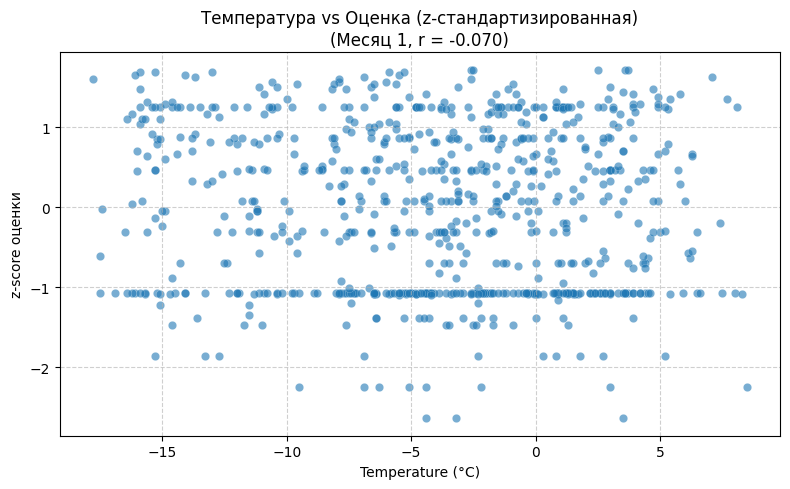

In [18]:
if best_group_desc == "Весь год":
    plot_data = df_corr
elif best_group_desc.startswith("Сезон "):
    season_name = best_group_desc.replace("Сезон ", "")
    plot_data = df_corr[df_corr['Seasons'] == season_name]
elif best_group_desc.startswith("Месяц "):
    month_num = int(best_group_desc.replace("Месяц ", ""))
    plot_data = df_corr[df_corr['Month'] == month_num]
else:
    plot_data = df_corr

plt.figure(figsize=(8, 5))
plt.scatter(plot_data['Temperature'], plot_data['z_score'], alpha=0.6, edgecolor='w', linewidth=0.2)
plt.title(f'Температура vs Оценка (z-стандартизированная)\n({best_group_desc}, r = {best_r:.3f})', fontsize=12)
plt.xlabel('Temperature (°C)')
plt.ylabel('z-score оценки')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()